*Examples have been upgraded to work with scikit-learn 0.23.1.*

In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes
from  matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.inspection import partial_dependence, plot_partial_dependence

!pip install -q -U pdpbox
!pip install -q -U rfpimp
!pip install -q -U stratx

from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from stratx import *

#%config InlineBackend.figure_formats = ['svg','png']

In [2]:
from support import *  # CHECK OUT THE support.py FILE IN THIS DIR

# Synthetic data to check whether StratPD captures relationships

Partial dependence plots of $n=2000$ data generated from noiseless $y = x_1^2 + x_1 x_2 + 5 x_1 sin(3 x_2) + 10$ where $x_1,x_2,x_3 \sim U(0,10)$ and $x_3$ does not affect $y$.

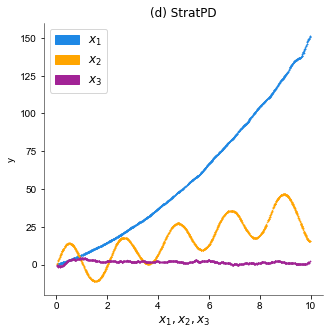

In [3]:
n = 2000
df = synthetic_interaction_data(n)

X, y = df[['x1', 'x2', 'x3']].copy(), df['y'].copy()
X1 = X.iloc[:, 0]
X2 = X.iloc[:, 1]
X3 = X.iloc[:, 2] # UNUSED in y

fig, ax = plt.subplots(1,1,figsize=(5,5))

x1_color = '#1E88E5'
x2_color = 'orange'
x3_color = '#A22396'

plot_stratpd(X, y, "x1", "y", ax=ax, pdp_marker_size=1,
             pdp_marker_color=x1_color,
             show_x_counts=False, n_trials=1, show_slope_lines=False)
plot_stratpd(X, y, "x2", "y", ax=ax, pdp_marker_size=1,
             pdp_marker_color=x2_color,
             show_x_counts=False, n_trials=1, show_slope_lines=False)
plot_stratpd(X, y, "x3", "y", ax=ax, pdp_marker_size=1,
             pdp_marker_color=x3_color,
             show_x_counts=False, n_trials=1, show_slope_lines=False)
ax.set_xticks([0,2,4,6,8,10])
ax.set_ylim(-20,160)
ax.set_yticks([0, 25, 50, 75, 100, 125, 150])
ax.set_xlabel("$x_1, x_2, x_3$", fontsize=12)
ax.set_title("(d) StratPD")
ax.spines['top'].set_linewidth(.5)
ax.spines['right'].set_linewidth(.5)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
x1_patch = mpatches.Patch(color=x1_color, label='$x_1$')
x2_patch = mpatches.Patch(color=x2_color, label='$x_2$')
x3_patch = mpatches.Patch(color=x3_color, label='$x_3$')
ax.legend(handles=[x1_patch,x2_patch,x3_patch], fontsize=12)
plt.show()

# The effect of noise

Curves for noisy quadratics generated from $y = x_1^2 + x_2 + 10 + \epsilon$ where $\epsilon \sim N(0,\sigma)$ $\epsilon$ and, at $\sigma=2$, 95\% of the noise falls within [0,4] (since $2\sigma = 4$), meaning that the signal-to-noise ratio is at best 1-to-1 for $x_1^2$ in $[-2,2]$.  The most noisy version on far right is highly variable actually.

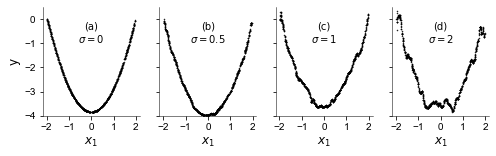

In [4]:
def noisy_poly_data(n, sd=1.0):
    x1 = np.random.uniform(-2, 2, size=n)
    x2 = np.random.uniform(-2, 2, size=n)

    y = x1 ** 2 + x2 + 10 + np.random.normal(0, sd, size=n)
    df = pd.DataFrame()
    df['x1'] = x1
    df['x2'] = x2
    df['y'] = y
    return df

n = 1000
fig, axes = plt.subplots(1, 4, figsize=(8, 2), sharey=True)
sds = [0,.5,1,2]
for i,sd in enumerate(sds):
    df = noisy_poly_data(n=n, sd=sd)
    X = df.drop('y', axis=1)
    y = df['y']
    plot_stratpd(X, y, 'x1', 'y',
                 show_ylabel=False,
                 pdp_marker_size=1,
                 show_x_counts=False,
                 ax=axes[i], yrange=(-4, .5))
axes[0].set_ylabel("y", fontsize=12)

for i,(ax,which) in enumerate(zip(axes,['(a)','(b)','(c)','(d)'])):
    ax.text(0, -1, f"{which}\n$\sigma = {sds[i]}$", horizontalalignment='center')
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_xticks([-2,-1,0,1,2])
    
plt.show()

# NYC apt rent

*Data use rules prevent me from storing this data in this repo*. Download the data set from Kaggle. (You must be a registered Kaggle user and must be logged in.) Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data) and save `train.json` into the `data` directory underneath this notebook. 

In [5]:
n = 10_000
X, y = load_rent(n=n)
X.head()

Rent has 49352 records


,bedrooms,bathrooms,latitude,longitude,interest_level,hells,astoria,Evillage,Wvillage,LowerEast,UpperEast,ParkSlope,Prospect Park,Crown Heights,financial,brooklynheights,gowanus,num_photos,num_desc_words,num_features
49785,1,1.0,40.7396,-73.9816,1,33.4,100.0796,19.665620,25.79,27.2394,50.834098,71.733,390.15,123.206392,59.836126,42.913860,82.0,8,85,0
16779,4,1.0,40.8007,-73.9609,2,70.0,60.3428,101.465620,107.59,109.0394,34.106910,144.459,349.75,163.606392,141.636126,124.713860,163.8,6,68,1
44287,3,2.0,40.7518,-73.9944,3,12.4,100.6796,38.206832,25.19,46.8946,51.434098,96.733,365.15,148.206392,59.236126,56.761758,81.4,11,106,9
99273,1,1.0,40.7845,-73.9503,2,64.4,33.5428,95.865620,101.99,103.4394,25.365902,138.859,376.55,136.806392,136.036126,119.113860,158.2,6,135,8
30233,1,1.0,40.7538,-73.9740,1,26.8,78.2796,41.465620,47.59,49.0394,29.034098,84.459,383.55,129.806392,81.636126,64.713860,103.8,5,72,5


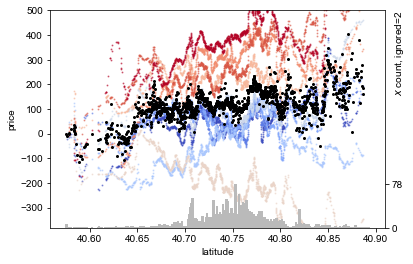

In [6]:
# This one is highly variable depending on subset we choose.
plot_stratpd(X, y, 'latitude', 'price', n_trials = 10, yrange=(-200,500))
plt.show()

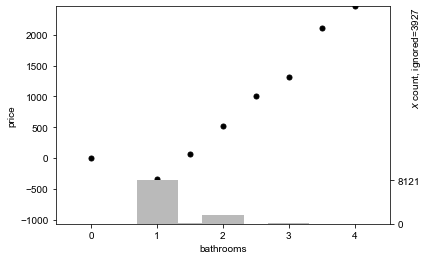

In [7]:
plot_stratpd(X, y, 'bathrooms', 'price', pdp_marker_size=10)
plt.show()

# Bulldozer sales

*Data use rules prevent me from storing this data in this repo*. Download the data set from Kaggle. (You must be a registered Kaggle user and must be logged in.) Go to the Kaggle [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/data) and save `Train.csv` into the `data` directory underneath this notebook.

The raw csv is superslow to load, but feather is fast so load it'll load first time as csv then save as feather, which loads next time.

In [8]:
! pip install -q pyarrow
X, y = load_bulldozer(10_000)
X.head()

Loading cached version...
Bulldozer has 362781 records


,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,MachineHours_na,saleyear,salemonth,saleday,saledayofweek,saledayofyear
364224,1376,172,1998,1.0,20136.0,12,0,4,0,2010,12,9,3,343
398873,28571,172,1990,1.0,14585.0,21,1,4,0,2011,12,13,1,347
391892,19340,121,2005,3.0,606.0,6,0,0,0,2011,9,22,3,265
367674,75,132,2006,2.0,3138.0,5,1,3,1,2011,2,3,3,34
351829,4664,149,1986,1.0,3138.0,24,0,0,1,2010,7,14,2,195


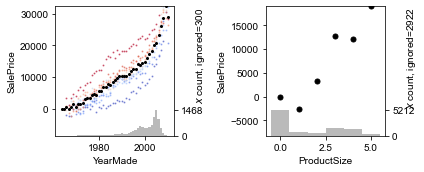

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

plot_stratpd(X, y, colname='YearMade', targetname='SalePrice', ax=axes[0], n_trials=10)
plot_stratpd(X, y, colname='ProductSize', targetname='SalePrice', ax=axes[1], pdp_marker_size=10)

plt.tight_layout()
plt.show()

# Synthetic human weight data

We synthesized a body weight data set generated by the following equation with nontrivial codependencies between variables: 

<img src="weight_equation.png" width="600">

In [10]:
X, y, df, eqn = toy_weight_data(6)
df.head(3)

,sex,pregnant,height,education,weight
0,0,0,64.082978,10,132.127062
1,0,0,62.010902,14,105.406300
2,0,0,74.017536,15,223.972638


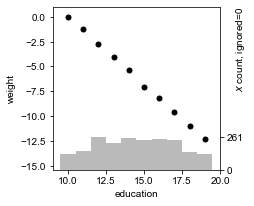

In [11]:
X, y, df, eqn = toy_weight_data(2000)

fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_stratpd(X, y, 'education', 'weight', ax=ax,
             yrange=(-12, 1),
             show_x_counts=True,
             pdp_marker_size=10)
plt.show()

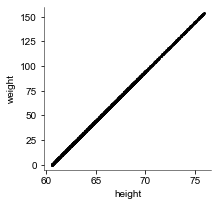

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_stratpd(X, y, 'height', 'weight', ax=ax,
             show_x_counts=False,
             yrange=(-5,160),
             pdp_marker_size=3)
plt.show()

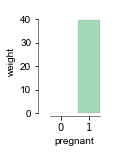

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1.3,2))
plot_catstratpd(X, y, 'pregnant', 'weight', ax=ax,
                show_x_counts=False,
                catnames={0:'False',1:'True'},
                yrange=(-1, 45),
                )
plt.show()

# Toy weather data with sine curve

In [14]:
from collections import OrderedDict

df = toy_weather_data()
df_string_to_cat(df)
names = np.unique(df['state'])
catnames = OrderedDict()
for i,v in enumerate(names):
    catnames[i+1] = v
df_cat_to_catcode(df)

X = df.drop('temperature', axis=1)
y = df['temperature']

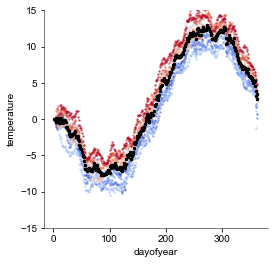

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
plot_stratpd(X, y, 'dayofyear', 'temperature', ax=ax,
             show_x_counts=False,
             yrange=(-15, 15),
             pdp_marker_size=3, slope_line_alpha=.8, n_trials=10)
plt.show()

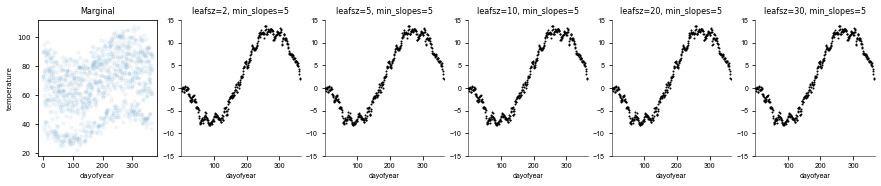

In [16]:
plot_stratpd_gridsearch(X, y, 'dayofyear', 'temperature',
             show_x_counts=False,
             yrange=(-15, 15))             
plt.show()

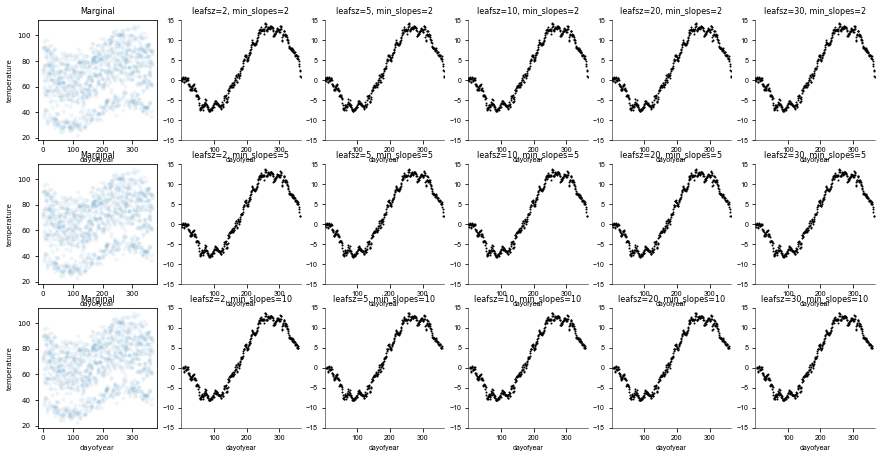

In [17]:
plot_stratpd_gridsearch(X, y, 'dayofyear', 'temperature',
             show_x_counts=False,
             min_slopes_per_x_values=[2,5,10],
             yrange=(-15, 15))             
plt.show()

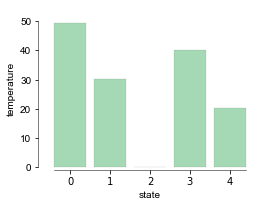

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
plot_catstratpd(X, y, 'state', 'temperature', catnames=catnames,
                show_x_counts=False,
                min_y_shifted_to_zero=True,
                ax=ax,
                yrange=(-1, 55))
plt.show()

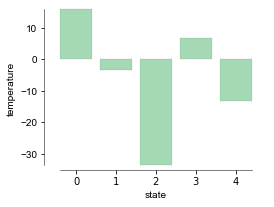

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
plot_catstratpd(X, y, 'state', 'temperature', catnames=catnames,
                show_x_counts=False,
                min_y_shifted_to_zero=False,
                ax=ax,
               )
plt.show()